参考URL：
https://github.com/vickyliin/gradcam_plus_plus-pytorch
https://qiita.com/bamboo-nova/items/082f71b96b9aca0d5df5

In [26]:
import os
import sys
from pathlib import Path
import random

sys.path.append(os.path.join(Path().resolve(), '..'))

import PIL
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

from utils.utils import make_datapath_list, ImageTransform

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [82]:
path = "../data/test"
img_num = 5
files = make_datapath_list(path)
files = random.sample(files, img_num)  # フォルダ全てだと多いので10枚まで

../data/test/**/*.tif


In [19]:
class CamImageTransform(ImageTransform):
    def __init__(self, size=224, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],
                 grayscale_flag=False, normalize_per_img=False):
        super().__init__(size=224, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],
                         grayscale_flag=False, normalize_per_img=False)
        
    def __call__(self, img, phase, is_norm):
        img = self.transform[phase](img)
        if self.normalize_per_img:
            self.mean = torch.mean(img, dim=(1,2))
            self.std = torch.std(img, dim=(1,2))
        if is_norm:
            normalize = transforms.Normalize(self.mean, self.std)
            img = normalize(img)
        return img

In [67]:
transform = CamImageTransform()
torch_imgs = []
normed_torch_imgs = []

for file in files:
    img = PIL.Image.open(file)
    torch_imgs.append(transform(img, phase="val", is_norm=False).unsqueeze(0))
    normed_torch_imgs.append(transform(img, phase="val", is_norm=True).unsqueeze(0).unsqueeze(0))
    
torch_imgs = torch.cat(torch_imgs, 0).to(device)
normed_torch_imgs = torch.cat(normed_torch_imgs, 0).to(device)
print(torch_imgs.size())
print(normed_torch_imgs.size())

torch.Size([5, 3, 224, 224])
torch.Size([5, 1, 3, 224, 224])


In [74]:
model = models.resnet101(pretrained=True)
fc_input_dim = model.fc.in_features
model.fc = nn.Sequential(nn.Dropout(0.4), nn.Linear(fc_input_dim, 8))
model.to(device).eval()
model.load_state_dict(torch.load('../weight/weight_2020-12-08-14-24-28_71.pth'))

<All keys matched successfully>

In [75]:
target_layer = model.layer4
gradcam = GradCAM(model, target_layer)
gradcam_pp = GradCAMpp(model, target_layer)

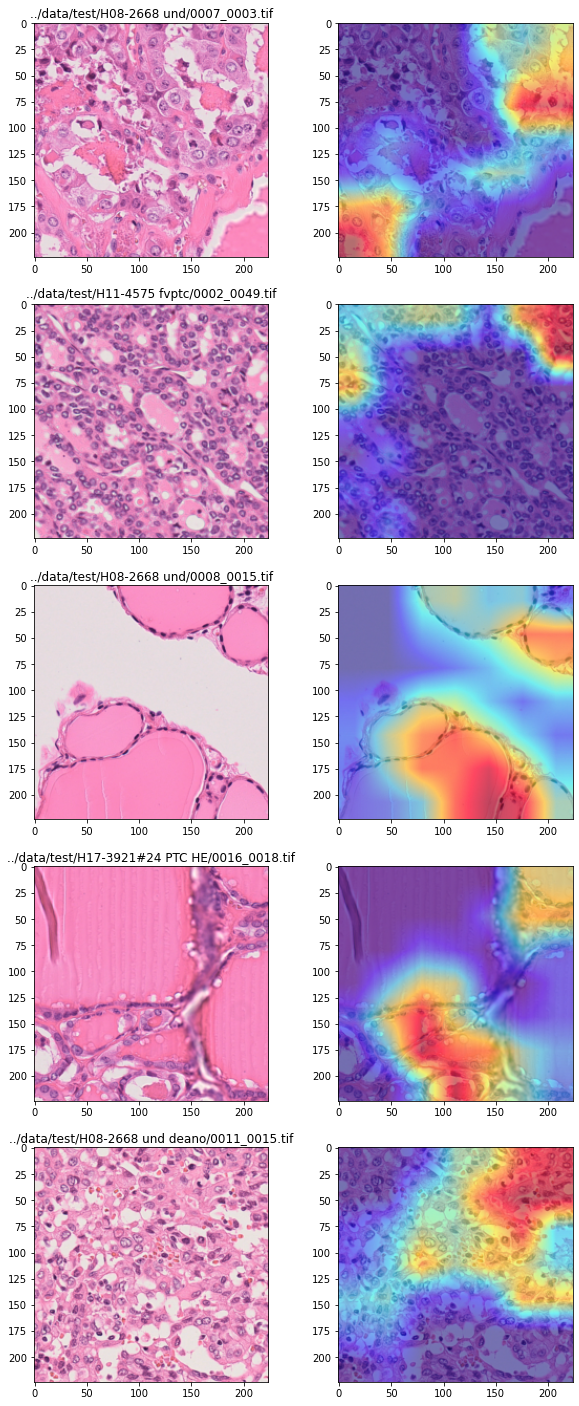

In [93]:
fig, ax = plt.subplots(ncols=2, nrows=img_num, figsize=(10, 25))
for i,file in enumerate(range(img_num)):
    mask, _ = gradcam(normed_torch_imgs[i])
    heatmap, result = visualize_cam(mask, torch_imgs[i])
    ax[i][0].set_title(files[i])
    ax[i][0].imshow(torch_imgs[i].to("cpu").numpy().transpose((1,2,0)))
    ax[i][1].imshow(result.to("cpu").numpy().transpose((1,2,0)))